In [1]:
from utils.config import CONFIG
CONFIG.PSP_USE_MEAN = True
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
from psp.pSp_pure import pSp
from utils.dataset import MulticlassImageDataset
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
output_dir = Path("output/paper/latent_space_exploration")
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
covid_ckpt = torch.load("output/psp_pure_pneumonia_chosen_softer/checkpoint/psp_pure_pneumonia_chosen_softer.pt", map_location="cuda:1")
covid_net = pSp(covid_ckpt).to("cuda:1")
covid_net.latent_avg = covid_net.latent_avg.to("cuda:1") if covid_net.latent_avg is not None else None
covid_net.eval()
covid_dataset = MulticlassImageDataset(
    ["input/data/covid_ct_pneumonia/train"],
    ["lung", "localizer", "bones", "drr", "soft"],
)
covid_dataloader = DataLoader(
    covid_dataset,
    batch_size=8,
    shuffle=False,
)
del covid_ckpt

Loading images from each class: 100%|██████████| 5/5 [00:24<00:00,  4.80s/it]


In [4]:
lidc_ckpt = torch.load("output/psp_pure_lidc_chosen_softer/checkpoint/160000.pt", map_location="cuda:2")
lidc_net = pSp(lidc_ckpt).to("cuda:2")
lidc_net.latent_avg = lidc_net.latent_avg.to("cuda:2") if lidc_net.latent_avg is not None else None
lidc_net.eval()
lidc_dataset = MulticlassImageDataset(
    ["input/data/lidc/train"],
    ["lung", "localizer", "bones", "drr", "soft"],
)
lidc_dataloader = DataLoader(
    lidc_dataset,
    batch_size=8,
    shuffle=False,
)
del lidc_ckpt

Loading images from each class: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


In [5]:
def to_device(tensor_dict, device: str = "cuda"):
    output = {k: v.to(device) for k, v in tensor_dict.items()}
    return output


def get_w_plus(net, item, device):
    return net(to_device(item, device)["lung"])[1]

def get_w_pluses(net, dataloader, device):
    with torch.no_grad():
        w_plus_list = [get_w_plus(net, item, device) for item in tqdm(dataloader)]
    return torch.concat(w_plus_list, dim=0)

def plot(img):
    fig, ax = plt.subplots(1, 1, figsize=(25,25))
    ax.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")


In [6]:
covid_w = get_w_pluses(covid_net, covid_dataloader, "cuda:1").detach().cpu().numpy()
lidc_w = get_w_pluses(lidc_net, lidc_dataloader, "cuda:2").detach().cpu().numpy()

100%|██████████| 85/85 [00:25<00:00,  3.39it/s]


In [7]:
covid_w = covid_w.reshape((covid_w.shape[0], -1))
lidc_w = lidc_w.reshape((lidc_w.shape[0], -1))

In [8]:
covid_n = covid_w.shape[0]
lidc_n = lidc_w.shape[0]

In [9]:
w_pluses = np.concatenate([covid_w, lidc_w], axis=0)
w_pluses.shape

(1322, 7168)

In [10]:
tsne = TSNE(n_components=2, perplexity=40, verbose=1, n_iter=5000)
tsne_result = tsne.fit_transform(w_pluses)

/home/user/mambaforge/envs/user/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/user/mambaforge/envs/user/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1322 samples in 0.008s...
[t-SNE] Computed neighbors for 1322 samples in 1.221s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1322
[t-SNE] Computed conditional probabilities for sample 1322 / 1322
[t-SNE] Mean sigma: 2.203159
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.191521
[t-SNE] KL divergence after 5000 iterations: 1.321879


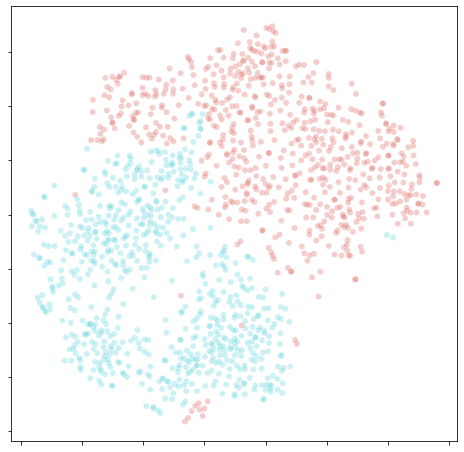

In [11]:
df = pd.DataFrame()
df["dim_0"] = tsne_result[:,0]
df["dim_1"] = tsne_result[:,1]
df["dataset"] = "covid_pneumonia"
df.loc[covid_n:, "dataset"] = "non_pneumonia"
plt.figure(figsize=(8,8))
img = sns.scatterplot(
    x="dim_0", y="dim_1",
    hue="dataset",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend=None,
    alpha=0.3
);
img.set(xlabel=None);
img.set(xticklabels=[]);
img.set(ylabel=None);
img.set(yticklabels=[]);